# a quick pygama demo

`pygama` is built for speed, and doesn't require us to write in a lower-level language like C to get it. Core processing operations are optimized and parallellized as much as possible, using tools like `pandas`, `numpy`, `hdf5`, `multiprocessing`, and `cython` to do the heavy lifting.

Processing is split into a Tier system:
- **Tier 0** : Raw DAQ data, containing many data takers

- **Tier 1** : Pandas DataFrames, with waveform samples stored in separate columns

- **Tier 2** : DataFrame containing single-valued output only (no waveforms).  

Without waveforms, files can be made extremely small and fast for calculations like pulser tagging, event building, deadtime, and energy calibration.  There is nothing stopping us from combining the Tier 2 results back with the original waveforms for higher-Tier, more advanced processing (such as retrieving all waveforms which pass high-level cuts).  

(Soon we'll add a class that can quickly concatenate many Tier 1 files (one for each run!) to construct Data Sets.)


The work is done by two main processing functions:

- **ProcessTier0 (tier0.py)** 
    `Raw data --> Pandas DataFrame (Tier 1)`  
    
    Uses pygama's `DataLoader` objects such as `Digitizer` and `Poller` to extract the raw data in a single loop over the raw file.  (Side note: This loop can optionally be cythonized for extra speed.)
    
    Saves the data in a format which can be "chunked," where we can quickly open subsets of a DataFrame for processing, just like a `ROOT TTree`.  Internally this uses `pytables`, which has an internal limitation on the number of columns (3000), in exchange for superfast selection of the subsets with `pandas.HDFStore` .
    
    Writes Tier 1 DataFrames to HDF5.  Uses compression: blosc:snappy.  I picked this after reading [this blog post](https://dziganto.github.io/out-of-core%20computation/HDF5-Or-How-I-Learned-To-Love-Data-Compression-And-Partial-Input-Output/).
  
  
- **ProcessTier1 (tier1.py)**
    `Tier 1 DataFrame --> Tier 2 DataFrame`

    The Tier 1 data is processed in **chunks**, i.e large blocks of waveforms saved into `numpy.ndarray` objects.  Numpy operations are highly optimized for speed (taking advantage of C and Fortran libraries) and operations on entire `ndarray` objects can be performed **significantly faster** than loop-based iteration over rows.  This is often called **vectorizing** and can make things very fast.  

    The `multiprocessing` module allows another big speedup.  By selecting "blocks" of waveforms with fast HDF5 indexing, we can process each block in parallel and combine the output at the end, using as many threads as are available on the system (supercomputers can have lots and lots of threads on every node!)

    To facilitate calculations or transforms which may depend on others, we keep a list of `Calculator` or `Transformer` objects which operate on an internal "intercom" that stores blocks of waveforms and columns of calculator results.  
    
    Writes Tier 2 DataFrames to HDF5, and optionally also saves (transformed) waveforms.

  

In [1]:
import time, glob
import numpy as np
import pandas as pd

In [2]:
# set some options

data_dir = "/Users/wisecg/project/pygama"

# run = 42343
run = 72

# pygama user options - could even read these in from json config files
t0_options = {
    42343: {"digitizer":"ORGretina4MWaveformDecoder", "n_blsamp":500},
    72: {"digitizer":"ORSIS3302DecoderForEnergy",
         "window":"max", # max or tp
         "n_samp":2000,
         "n_blsamp":10000}
    }
t1_options = {
    43243 : {"fit_baseline": {"i_end":500}},
    72 : {"fit_baseline": {"i_end":8000}}
    }

## Run ProcessTier0

Here we loop over the raw file.  They can be large, so we periodically write to our output file rather than storing the whole thing in memory at once.  It's less simple to parallelize this task, since each record's starting index depends on the previous one.  So we can cythonize `ProcessTier0` and related functions to squeeze out a little more speed.

In [3]:
from pygama.processing.tier0 import ProcessTier0

raw_file = glob.glob("{}/*Run{}".format(data_dir, run))[0]

n_evt = 50000
# n_evt = np.inf

ProcessTier0(raw_file,
             verbose=True,
             output_dir=data_dir,
             n_max=n_evt,
             settings=t0_options[run]) # pass in specific build options

Starting pygama Tier 0 processing ...
  Input file: /Users/wisecg/project/pygama/2018-9-30-BackgroundRun72
Total file size: 2010.030 MB
Run number: 72
Data IDs present in this header are:
    4: OR1DHistoDecoder
    5: ORRunDecoderForRun
    1: ORSIS3302DecoderForEnergy
    3: ORSIS3302DecoderForLostData
    2: ORSIS3302DecoderForMca
pygama will run these decoders:
    1: ORSIS3302DecoderForEnergy
Overwriting existing file...
Beginning Tier 0 processing ...
PROGRESS : [####################] 98.713% done.  last packet ID: 31404
Writing ORSIS3302DecoderForEnergy
Saving garbage: 52 of 31383 total events
PROGRESS : [####################] 100.000% Done...
Wrote: Tier 1 File:
    /Users/wisecg/project/pygama/t1_run72.h5
FILE INFO:
['/ORSIS3302DecoderForEnergy', '/ORSIS3302DecoderForEnergy_Garbage', '/ORSIS3302Model']
File size: 95.724 MB
Time elapsed: 25.05 sec
Done.



## Examine Tier 1 Output

Let's peek at the (multiple) DataFrames that ProcessTier0 has stored in our Tier 1 file.

In [4]:
t1_file = glob.glob("{}/t1_run{}.h5".format(data_dir, run))[0]

with pd.HDFStore(t1_file,'r') as store:

    for key in store.keys():
        s = store.get_storer(key)
        print(key, "\n   ", s)
        
        # df = store.get(key) # careful, it can be a lot to load in RAM

/ORSIS3302DecoderForEnergy 
    frame_table  (typ->appendable,nrows->31331,ncols->2007,indexers->[index])
/ORSIS3302DecoderForEnergy_Garbage 
    frame        (shape->[52,8])
/ORSIS3302Model 
    frame        (shape->[1,47])


## Run ProcessTier1

We declare a `Tier1Processor` and create the **list of calculations/transforms** we want to do.  This is a good place to convert a multisampled waveform, do a database lookup to get nonlinearity parameters, and run various transforms (waveform-valued) and calculators (single-valued).

In [9]:
from pygama.processing.base import Tier1Processor
from pygama.processing.tier1 import ProcessTier1

t1_file = glob.glob("{}/t1_run{}.h5".format(data_dir, run))[0]

# declare our processor list
proc = Tier1Processor(t1_options)
proc.add("fit_baseline", {"i_end":800})
proc.add("bl_subtract")
proc.add("trap_filter")
proc.add("trap_max", {"test":False})

# NOTE: using {'test':True} displays a plot,
# won't work when multiprocessing is enabled

# proc = Tier1Processor(t1_options, default_list=True) # cop out

ProcessTier1(t1_file,
             proc,
             out_prefix="t2",
             out_dir=data_dir,
             verbose=True,
             multiprocess=True,
             settings=t1_options[run])

Starting pygama Tier 1 processing ...
   Input file: /Users/wisecg/project/pygama/t1_run72.h5
Processing data from digitizer: ORSIS3302DecoderForEnergy
Found 31331 rows
PROGRESS : [####################] 100.000% Done...
Writing Tier 2 File:
   /Users/wisecg/project/pygama/t2_run72.h5
   Entries: 31331
   Data columns:
   -- channel
   -- energy
   -- energy_first
   -- event_number
   -- timestamp
   -- ts_hi
   -- bl_int
   -- bl_slope
   -- trap_max
File size: 3.540 MB
Time elapsed: 3.44 sec  (0.00011 sec/wf)
Done.


## Tier 2 Output

let's make some plots!

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use("../pygama/pygama.mplstyle")
from pygama.utils import get_hist

t2_file = glob.glob("{}/t2_run{}.h5".format(data_dir, run))[0]
t2_df = pd.read_hdf(t2_file)

<IPython.core.display.Javascript object>


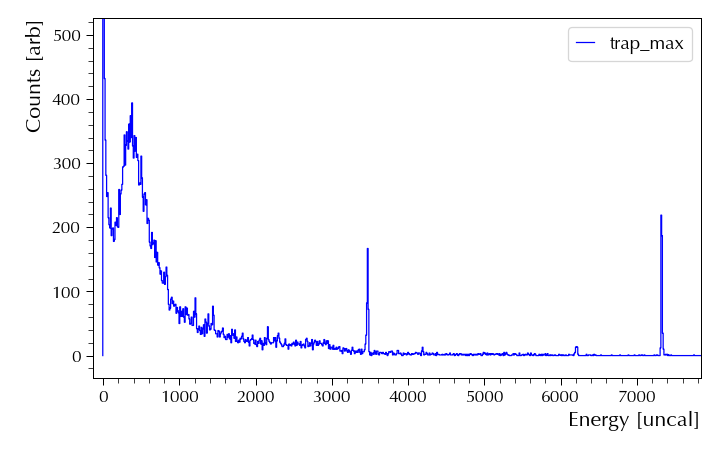

In [7]:
# set histogram limits
x_lo, x_hi, xpb = 0, 8000, 10
nb = int((x_hi-x_lo)/xpb)

# we can do this but i don't like its look
# t2_df.hist("trap_max", bins=nb, range=(x_lo, x_hi), label="trap_max")

# this is better
xH, yH = get_hist(t2_df["trap_max"], x_lo, x_hi, xpb)
plt.plot(xH, yH, c='b', lw=1, ls='steps', label="trap_max")

plt.xlabel("Energy [uncal]", ha='right', x=1)
plt.ylabel("Counts [arb]", ha='right', y=1)
plt.legend()
plt.tight_layout()